In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import glob
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, SeparableConv2D
from tensorflow.keras.models import Model, load_model

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
print("TensorFlow version:", tf.__version__)

1 Physical GPUs, 1 Logical GPUs
TensorFlow version: 2.10.1


In [2]:
# Memory optimization settings
import gc

# Set memory growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Optional: Limit GPU memory usage
        # tf.config.experimental.set_memory_limit(gpus[0], 1024)  # 1GB limit
        
    except RuntimeError as e:
        print(f"GPU setup error: {e}")

# Force garbage collection
gc.collect()

print("Memory optimization settings applied")

Memory optimization settings applied


In [6]:
# Step 2: Data Mapping Logic 

# Configuration
DATA_DIR = Path('../data/')
dataset_path = Path('../data/getty_images_cropped/')

BATCH_SIZE = 8
IMG_HEIGHT = 224
IMG_WIDTH = 224


# Verify data directory exists
if not DATA_DIR.exists():
    print(f"Error: Directory {DATA_DIR} not found.")
else:
    data =[]
    # Dataset : getty_images_cropped
    for img_path in dataset_path.glob("**/*.jpg"):
        filename = img_path.name
        age = int(img_path.parent.name)
        data.append({'path': str(img_path), 'age': age})
    
    # Tạo biến df chính thức
    df = pd.DataFrame(data)
    
    # Shuffle data (xáo trộn) để không bị sắp xếp theo thứ tự folder
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    NUM_CLASSES = df['age'].max()
    
    print(f"DataFrame created. Shape: {df.shape}")
    print(f"Total Age Groups: {NUM_CLASSES}")
    
    # Hiển thị 5 dòng đầu để kiểm tra
    print(df.head())

DataFrame created. Shape: (5273, 2)
Total Age Groups: 100
                                           path  age
0  ..\data\getty_images_cropped\001\001_022.jpg    1
1  ..\data\getty_images_cropped\070\070_407.jpg   70
2  ..\data\getty_images_cropped\050\050_403.jpg   50
3  ..\data\getty_images_cropped\065\065_337.jpg   65
4  ..\data\getty_images_cropped\060\060_096.jpg   60


C:\Users\PC\AppData\Local\Temp\ipykernel_9652\852923322.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='age', palette='viridis')


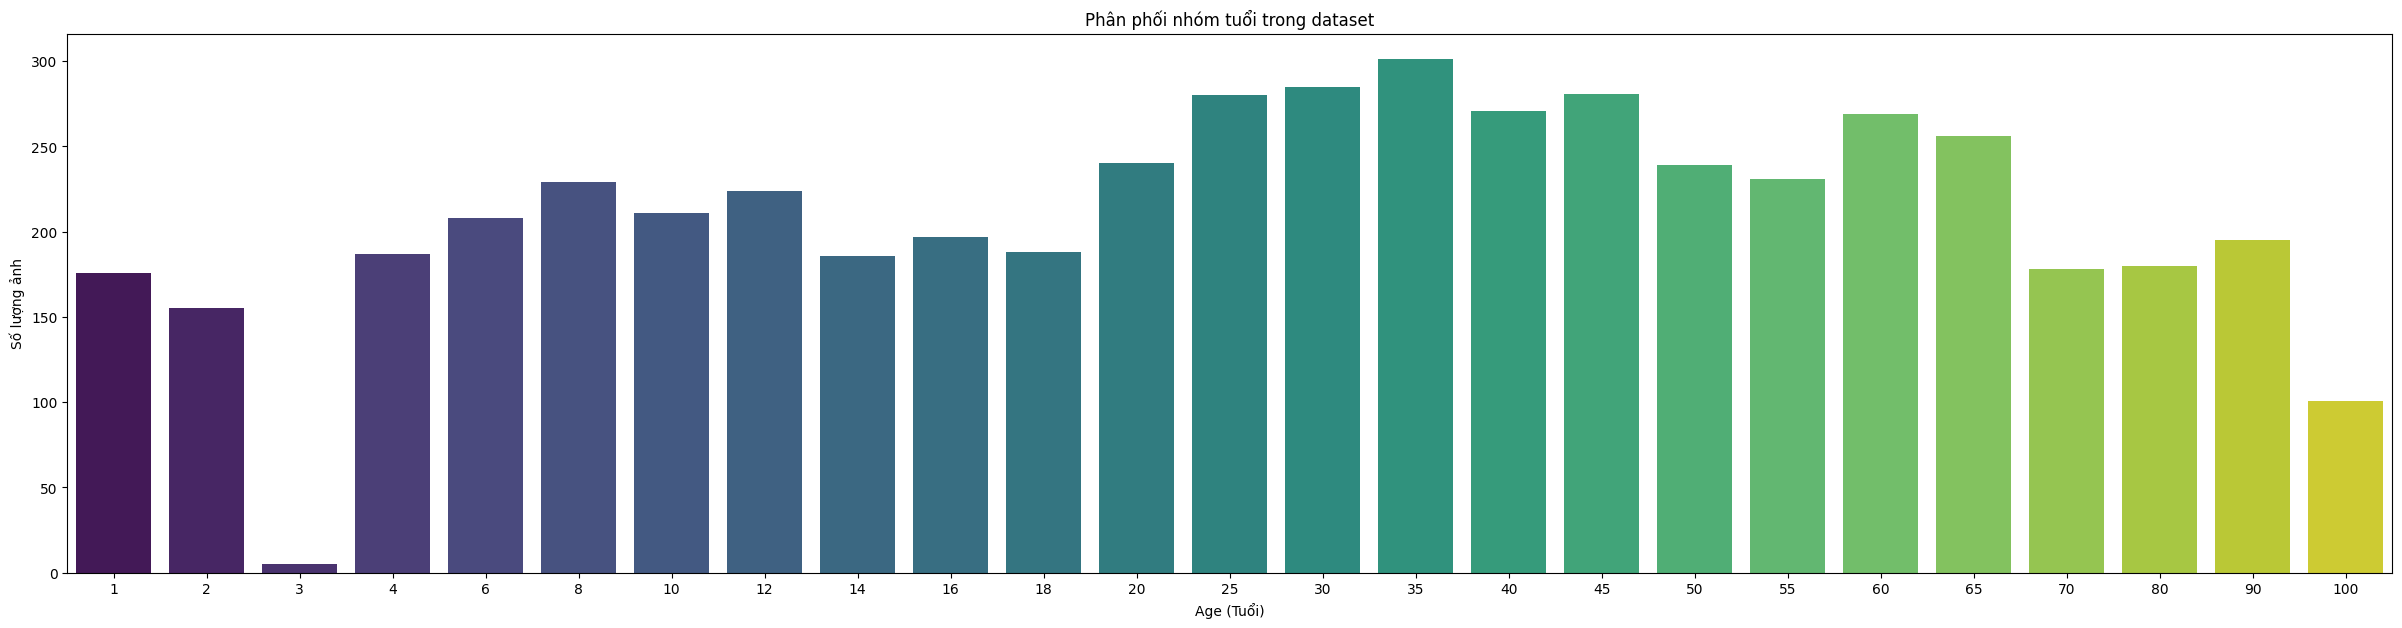

In [4]:
# Step 3: Data Visualization
plt.figure(figsize=(30, 7))
sns.countplot(data=df, x='age', palette='viridis')
plt.title('Phân phối nhóm tuổi trong dataset')
plt.xlabel('Age (Tuổi)')
plt.ylabel('Số lượng ảnh')
plt.show()


In [7]:
# Step 4 (Pre-computation): Split & Calculate Class Weights using DataFrame
# 1. Split Train/Validation (80/20)
# Stratify dựa trên cột age để đảm bảo chia đều các nhóm tuổi
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['age']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# 2. Adaptive Spreading - Trải dài dữ liệu cho TẤT CẢ các nhóm tuổi
def adaptive_spread_ages(train_df, spread_range=3, smoothness=0.5, spread_ratio=0.3):
    """
    Adaptive Spreading: Spread TẤT CẢ các mẫu để tạo phân bố mượt
    
    Args:
        train_df: DataFrame training
        spread_range: Khoảng tuổi trải rộng (±spread_range)
        smoothness: Độ mượt (0-1), càng cao càng ưu tiên spread sang tuổi gần
        spread_ratio: Tỷ lệ mẫu được spread (0-1)
    
    Returns:
        DataFrame đã được mở rộng
    """
    # Đánh dấu dữ liệu gốc
    train_df['is_spread'] = False
    
    # Danh sách lưu dữ liệu spread
    spread_data = []
    
    # Spread cho TẤT CẢ các mẫu với xác suất spread_ratio
    for idx, row in train_df.iterrows():
        # Random spread với xác suất spread_ratio
        if np.random.random() < spread_ratio:
            age = row['age']
            
            # Tạo distribution weights cho các tuổi lân cận
            possible_ages = list(range(max(age - spread_range, train_df['age'].min()),
                                      min(age + spread_range + 1, train_df['age'].max() + 1)))
            
            # Loại bỏ tuổi hiện tại để tạo spread thực sự
            possible_ages = [a for a in possible_ages if a != age]
            
            if possible_ages:
                # Tính weights dựa trên khoảng cách (Gaussian-like)
                weights = [np.exp(-smoothness * abs(a - age)) for a in possible_ages]
                weights = np.array(weights) / sum(weights)
                
                # Sample tuổi mới
                new_age = np.random.choice(possible_ages, p=weights)
                
                # Thêm mẫu spread
                spread_data.append({
                    'path': row['path'],
                    'age': new_age,
                    'is_spread': True
                })
    
    # Kết hợp dữ liệu gốc và spread
    if spread_data:
        spread_df = pd.DataFrame(spread_data)
        expanded_df = pd.concat([train_df, spread_df], ignore_index=True)
        
        # Xáo trộn dữ liệu
        expanded_df = expanded_df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        return expanded_df, len(spread_data)
    else:
        return train_df, 0

# Áp dụng Adaptive Spreading
train_df, spread_count = adaptive_spread_ages(train_df, spread_range=3, smoothness=0.5, spread_ratio=0.3)
print(f"✓ Added {spread_count} spread samples for smoother distribution")

Training samples: 4218
Validation samples: 1055
✓ Added 1303 spread samples for smoother distribution
✓ Added 1303 spread samples for smoother distribution


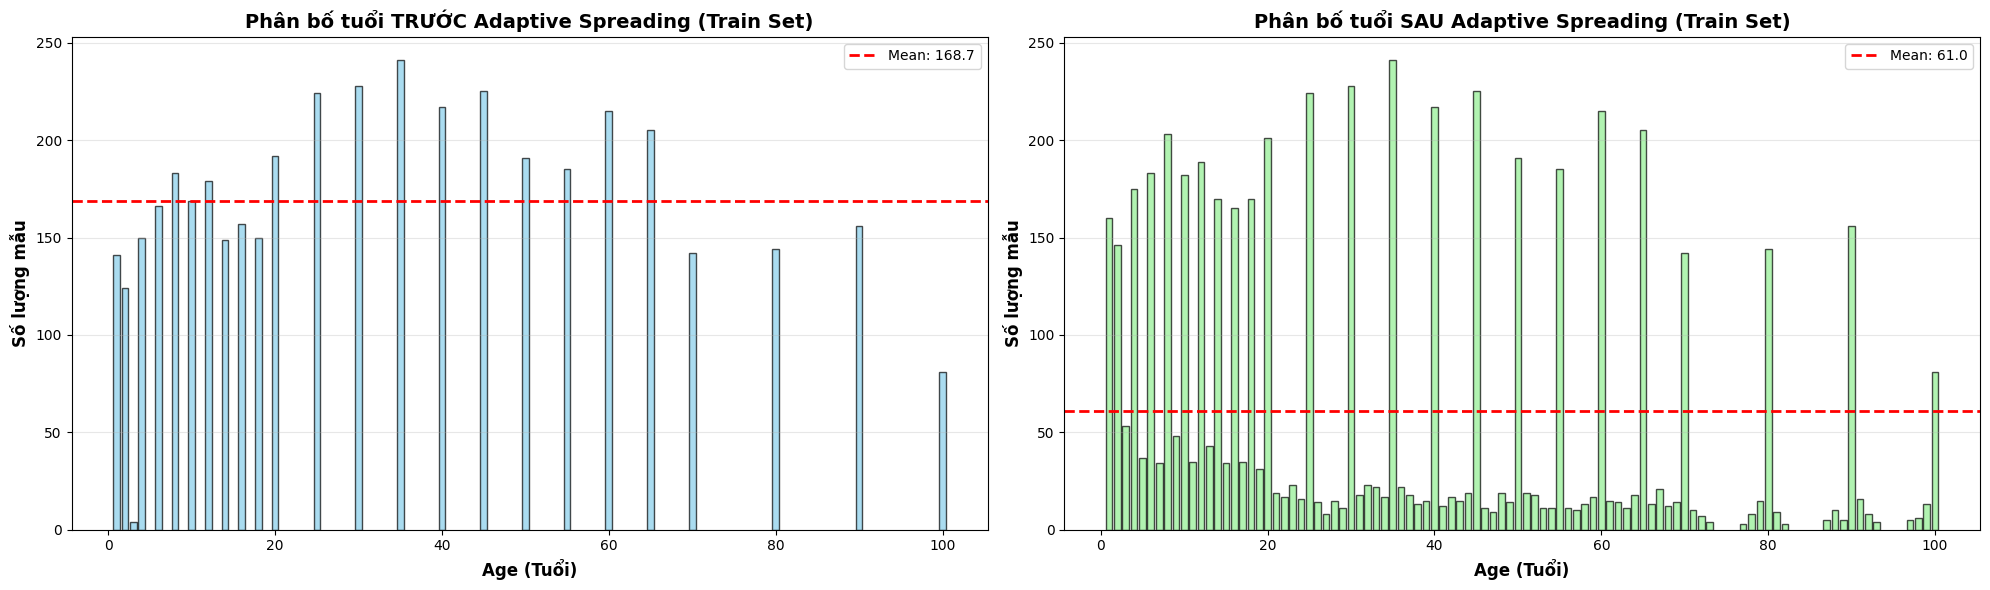


THỐNG KÊ PHÂN BỐ

TRƯỚC Adaptive Spreading:
   - Tổng mẫu: 4218
   - Trung bình mỗi nhóm tuổi: 168.7
   - Độ lệch chuẩn: 51.1
   - Min: 4 | Max: 241

SAU Adaptive Spreading:
   - Tổng mẫu: 5494
   - Trung bình mỗi nhóm tuổi: 61.0
   - Độ lệch chuẩn: 76.8
   - Min: 3 | Max: 241

CẢI THIỆN:
   - Giảm độ lệch chuẩn: -25.7
   - Tỷ lệ cải thiện: -50.3%



In [6]:
# Visualize Age Distribution Before and After Adaptive Spreading
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Lưu train_df gốc trước khi spreading (lọc bỏ cột is_spread nếu có)
train_df_original = train_df[train_df['is_spread'] == False].copy() if 'is_spread' in train_df.columns else train_df.copy()

# Before Adaptive Spreading
age_counts_before = train_df_original['age'].value_counts().sort_index()
axes[0].bar(age_counts_before.index, age_counts_before.values, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axhline(y=age_counts_before.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {age_counts_before.mean():.1f}')
axes[0].set_xlabel('Age (Tuổi)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Số lượng mẫu', fontsize=12, fontweight='bold')
axes[0].set_title('Phân bố tuổi TRƯỚC Adaptive Spreading (Train Set)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# After Adaptive Spreading
age_counts_after = train_df['age'].value_counts().sort_index()
axes[1].bar(age_counts_after.index, age_counts_after.values, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].axhline(y=age_counts_after.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {age_counts_after.mean():.1f}')
axes[1].set_xlabel('Age (Tuổi)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Số lượng mẫu', fontsize=12, fontweight='bold')
axes[1].set_title('Phân bố tuổi SAU Adaptive Spreading (Train Set)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('age_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print(f"\n{'='*60}")
print(f"THỐNG KÊ PHÂN BỐ")
print(f"{'='*60}")
print(f"\nTRƯỚC Adaptive Spreading:")
print(f"   - Tổng mẫu: {len(train_df_original)}")
print(f"   - Trung bình mỗi nhóm tuổi: {age_counts_before.mean():.1f}")
print(f"   - Độ lệch chuẩn: {age_counts_before.std():.1f}")
print(f"   - Min: {age_counts_before.min()} | Max: {age_counts_before.max()}")

print(f"\nSAU Adaptive Spreading:")
print(f"   - Tổng mẫu: {len(train_df)}")
print(f"   - Trung bình mỗi nhóm tuổi: {age_counts_after.mean():.1f}")
print(f"   - Độ lệch chuẩn: {age_counts_after.std():.1f}")
print(f"   - Min: {age_counts_after.min()} | Max: {age_counts_after.max()}")

print(f"\nCẢI THIỆN:")
print(f"   - Giảm độ lệch chuẩn: {age_counts_before.std() - age_counts_after.std():.1f}")
print(f"   - Tỷ lệ cải thiện: {((age_counts_before.std() - age_counts_after.std())/age_counts_before.std()*100):.1f}%")
print(f"{'='*60}\n")

In [8]:
# Step 3: Tf.data Pipeline Construction for Regression

AUTOTUNE = tf.data.AUTOTUNE

def process_path(file_path, age):
    """
    Memory-efficient image processing for Regression.
    Return age as a float32 scalar value.
    """
    # Load and decode image
    img = tf.io.read_file(file_path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    
    # Ensure 3 channels and convert to float32
    img = tf.ensure_shape(img, [None, None, 3])
    img = tf.cast(img, tf.float32)
    
    # Resize with memory efficiency
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH], method='bilinear')
    
    # Normalize to [0,1] range
    img = img / 255.0
    
    # Convert age to float32 for regression
    age_value = tf.cast(age, tf.float32)
    
    return img, age_value

def augment(image, label):
    """
    Applies random augmentation to training data.
    """
    # Random flip
    image = tf.image.random_flip_left_right(image)
    
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.1)
    
    # Random contrast
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    return image, label

# Create TensorFlow Datasets for Regression
train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'].values, train_df['age'].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'].values, val_df['age'].values))

# Apply transformations
# Train: Shuffle -> Process (regression) -> Batch -> Augment -> Prefetch
train_ds = train_ds.shuffle(buffer_size=len(train_df), seed=42, reshuffle_each_iteration=True)
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=1)

# Val: Process (regression) -> Batch -> Prefetch
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=1)

print("Pipeline built for Regression mode")
print(f"Training set size: {len(train_df)} samples")
print(f"Validation set size: {len(val_df)} samples")

# Check shape of one batch
for image_batch, labels_batch in train_ds.take(1):
    print(f"\nImage Batch Shape: {image_batch.shape}")
    print(f"Label Batch Shape (scalar): {labels_batch.shape}")
    print(f"Sample labels (ages): {labels_batch.numpy()[:5]}")
    break

Pipeline built for Regression mode
Training set size: 5521 samples
Validation set size: 1055 samples

Image Batch Shape: (8, 224, 224, 3)
Label Batch Shape (scalar): (8,)
Sample labels (ages): [12.  4.  8. 50. 20.]

Image Batch Shape: (8, 224, 224, 3)
Label Batch Shape (scalar): (8,)
Sample labels (ages): [12.  4.  8. 50. 20.]


In [ ]:
# Step 5: Regression Model Construction
# Treat age estimation as regression problem (output: continuous value)

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Feature extraction backbone
X = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer=glorot_uniform(seed=0))(inputs)
X = BatchNormalization()(X)

X = SeparableConv2D(64, (3, 3), padding='same', activation='relu')(X)
X = BatchNormalization()(X)
X = MaxPooling2D((2, 2))(X)

X = SeparableConv2D(128, (3, 3), padding='same', activation='relu')(X)
X = BatchNormalization()(X)
X = MaxPooling2D((2, 2))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = BatchNormalization()(X)
X = MaxPooling2D((2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = BatchNormalization()(X)
X = MaxPooling2D((2, 2))(X)

X = tf.keras.layers.GlobalAveragePooling2D()(X)

# Dense layers
X = Dense(256, activation='relu')(X)
X = Dropout(0.3)(X)
X = Dense(128, activation='relu')(X)
X = Dropout(0.3)(X)

# Regression output: single neuron with linear activation
output = Dense(1, activation='linear', name='age_output')(X)

model = Model(inputs=inputs, outputs=output)

print(f"✓ Regression Model created for age prediction (continuous output)")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 separable_conv2d (Separable  (None, 112, 112, 64)     4736      
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                             

In [ ]:
# Compile Regression Model with MSE Loss and MAE Metric

# Compile model for regression
model.compile(
    loss='mse',  # Mean Squared Error for regression
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']  # Mean Absolute Error
)

print("✓ Regression Model compiled with MSE loss")
print("✓ Using MAE metric for monitoring")

✓ Regression Model compiled with MSE loss
✓ Using MAE metric for monitoring


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 separable_conv2d (Separable  (None, 112, 112, 64)     4736      
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                             

In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',  # Monitor MAE instead of dex_mae_metric
    restore_best_weights=True,
    mode='min',
    patience=10,
    verbose=1
)
check_point = tf.keras.callbacks.ModelCheckpoint(
    'best_model_age.h5',  # Save as best_model_age.h5
    monitor='val_mae',  # Monitor MAE instead of dex_mae_metric
    save_best_only=True,
    mode='min',
    verbose=1
)

# Train Regression model
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop, check_point],
    verbose=1
)

Epoch 1/30
687/687 [==============================] - ETA: 0s - loss: 493.8748 - mae: 17.1866
Epoch 1: val_mae improved from inf to 14.53204, saving model to best_model_age.h5

Epoch 1: val_mae improved from inf to 14.53204, saving model to best_model_age.h5
687/687 [==============================] - 24s 32ms/step - loss: 493.8748 - mae: 17.1866 - val_loss: 348.6364 - val_mae: 14.5320
Epoch 2/30
Epoch 2/30
686/687 [============================>.] - ETA: 0s - loss: 322.3190 - mae: 13.8086
Epoch 2: val_mae did not improve from 14.53204
687/687 [==============================] - 22s 32ms/step - loss: 322.6083 - mae: 13.8169 - val_loss: 591.5435 - val_mae: 20.2866

Epoch 2: val_mae did not improve from 14.53204
687/687 [==============================] - 22s 32ms/step - loss: 322.6083 - mae: 13.8169 - val_loss: 591.5435 - val_mae: 20.2866
Epoch 3/30
Epoch 3/30
687/687 [==============================] - ETA: 0s - loss: 271.5621 - mae: 12.5002
Epoch 3: val_mae improved from 14.53204 to 12.483

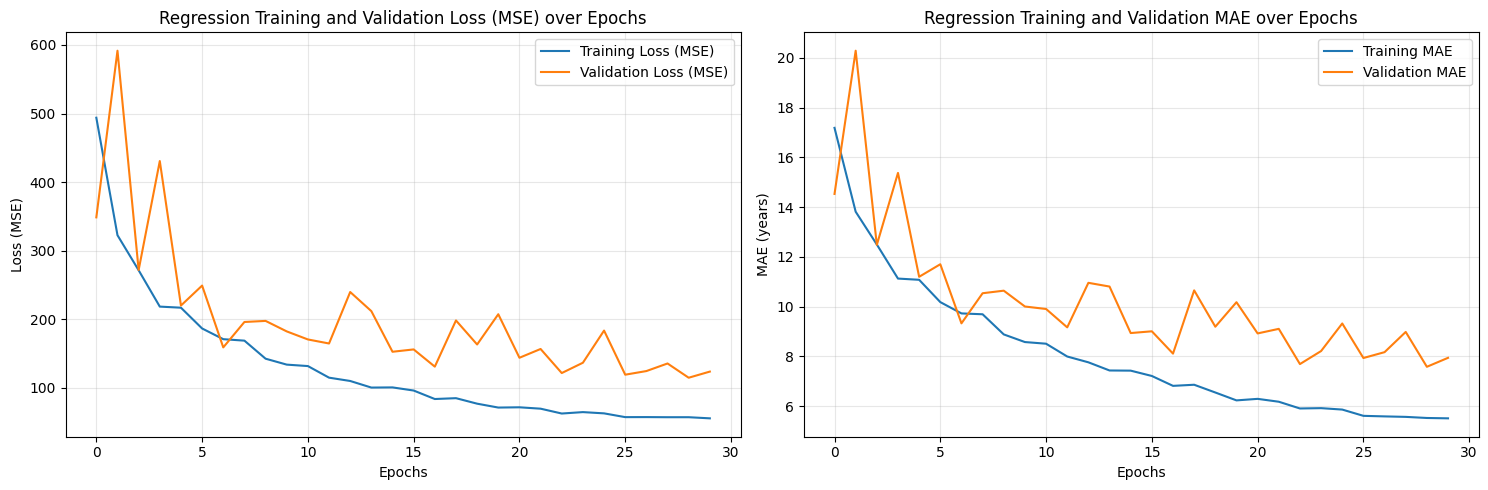

In [12]:
# Plot training history
training_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']
training_mae = model_history.history['mae']
validation_mae = model_history.history['val_mae']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
axes[0].plot(training_loss, label='Training Loss (MSE)')
axes[0].plot(validation_loss, label='Validation Loss (MSE)')
axes[0].set_title('Regression Training and Validation Loss (MSE) over Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot MAE
axes[1].plot(training_mae, label='Training MAE')
axes[1].plot(validation_mae, label='Validation MAE')
axes[1].set_title('Regression Training and Validation MAE over Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('MAE (years)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Evaluating Regression model...
Mean Absolute Error (MAE): 7.57 years
Root Mean Square Error (RMSE): 10.72 years
R² Score: 0.8327
Mean Absolute Error (MAE): 7.57 years
Root Mean Square Error (RMSE): 10.72 years
R² Score: 0.8327


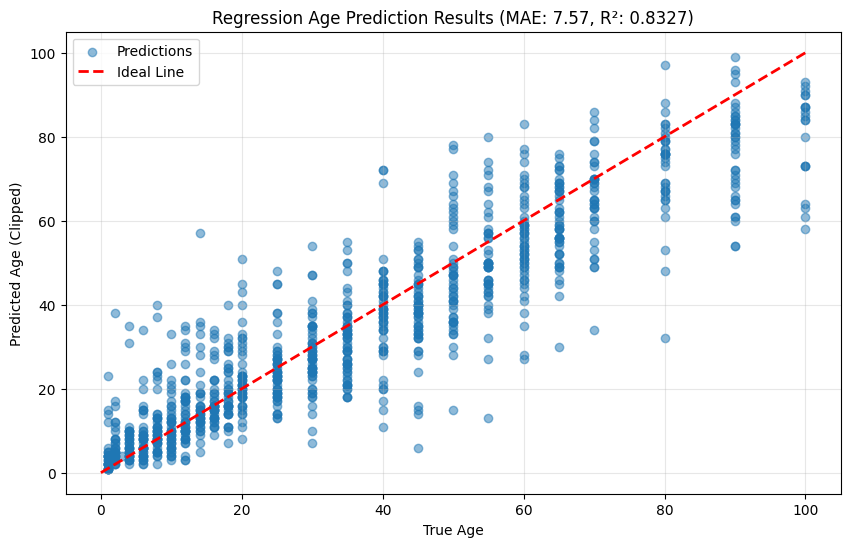

In [11]:
# Predict on validation set
print("Evaluating Regression model...")
y_true = []
y_pred_raw = []

for images, ages in val_ds:
    pred_ages = model.predict(images, verbose=0).flatten()
    
    true_ages = ages.numpy()
    
    y_true.extend(true_ages)
    y_pred_raw.extend(pred_ages)

y_true = np.array(y_true)
y_pred_raw = np.array(y_pred_raw)


y_pred_clipped = np.clip(y_pred_raw, 1, 100)
y_pred_final = np.round(y_pred_clipped)


# Calculate metrics
mae = mean_absolute_error(y_true, y_pred_final)
mse = mean_squared_error(y_true, y_pred_final)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred_final)

print(f"Mean Absolute Error (MAE): {mae:.2f} years")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} years")
print(f"R² Score: {r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred_final, alpha=0.5, label='Predictions')

# Vẽ đường chuẩn (Ideal Line) cố định từ 0 đến 100
plt.plot([0, 100], [0, 100], 'r--', lw=2, label='Ideal Line')

plt.xlabel('True Age')
plt.ylabel('Predicted Age (Clipped)')
plt.title(f'Regression Age Prediction Results (MAE: {mae:.2f}, R²: {r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
# Load best Regression model
model = load_model('best_model_age.h5')

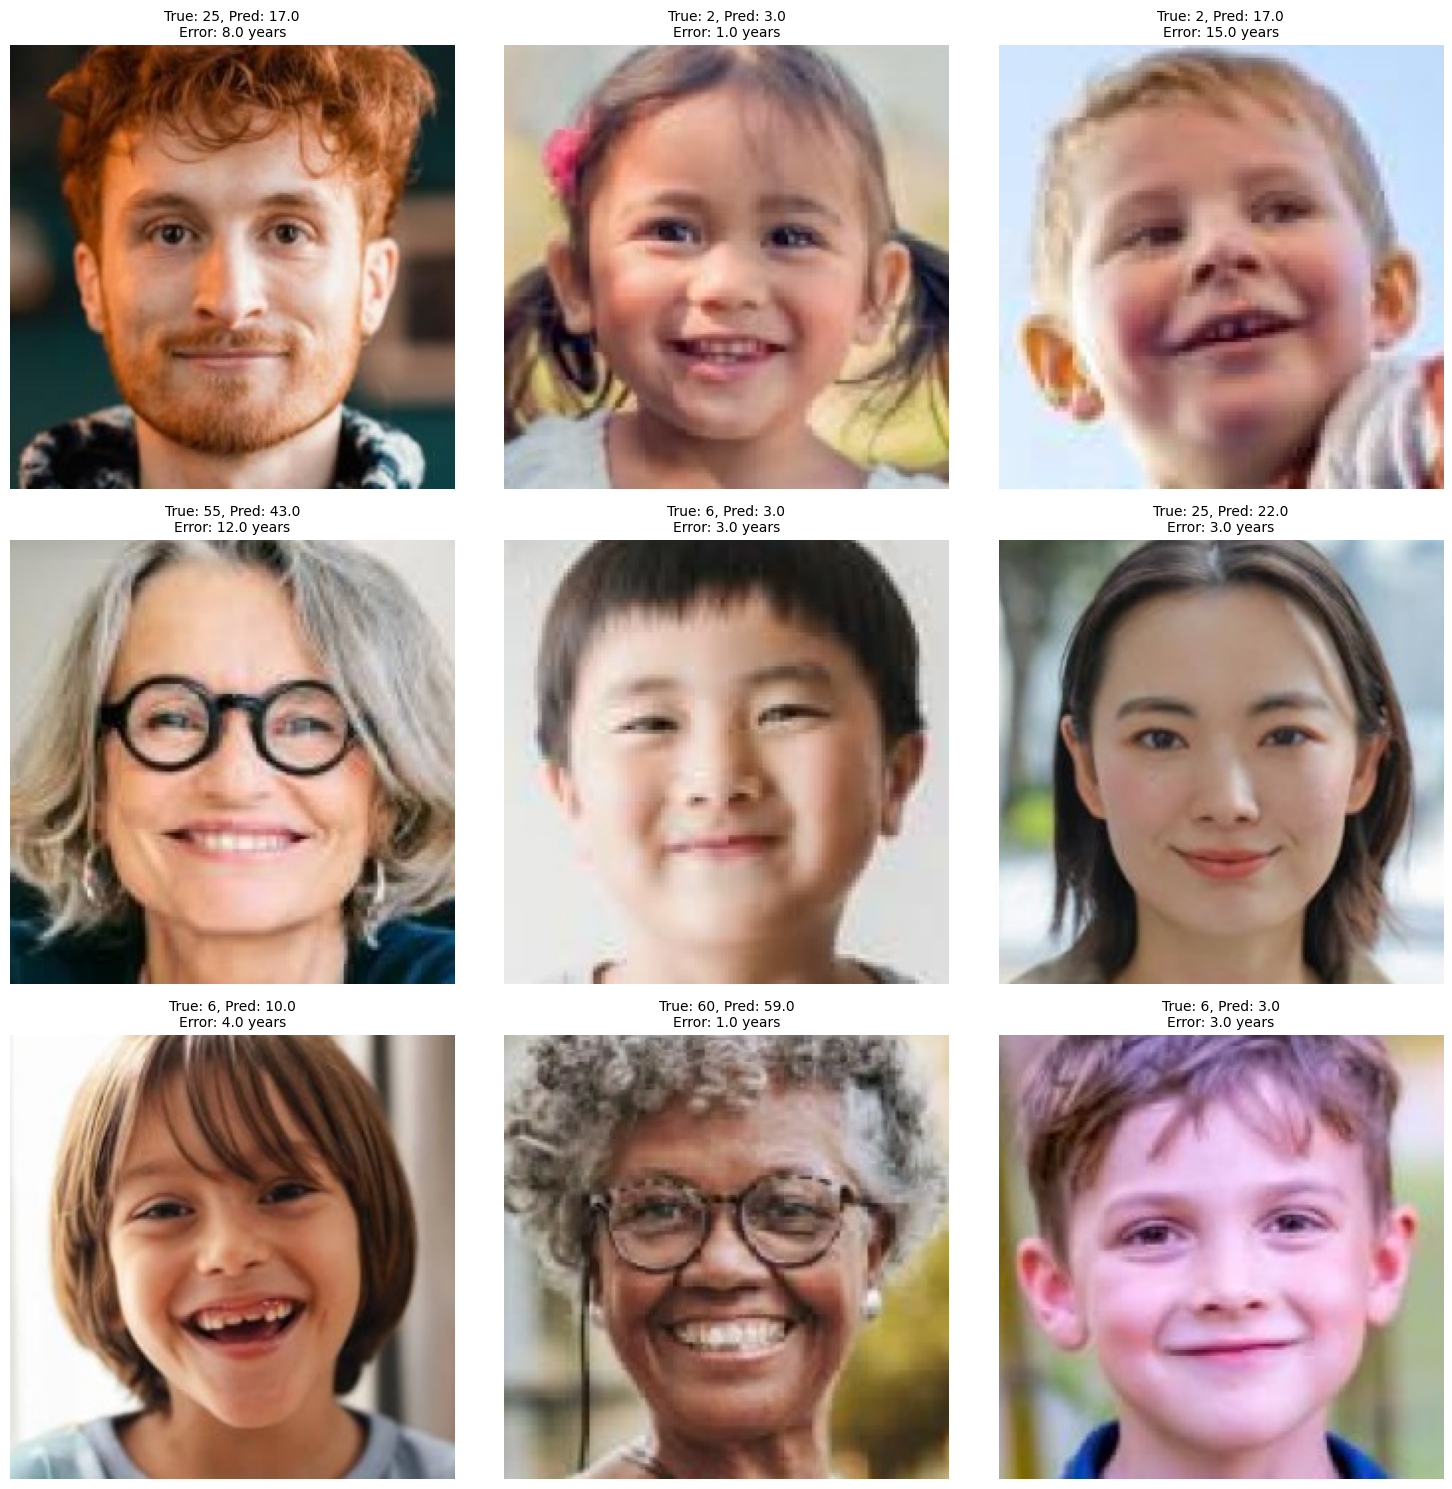

In [18]:
# Visualize Regression predictions
import random
random_indices = random.sample(range(len(val_df)), 9)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    img_path = val_df.iloc[idx]['path']
    true_age = val_df.iloc[idx]['age']
    
    # Load and preprocess image
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict age (regression output)
    predicted_age = model.predict(img_array, verbose=0)[0][0].round()
    
    # Calculate absolute error
    error = abs(true_age - predicted_age)
    
    # Plotting
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'True: {true_age}, Pred: {predicted_age:.1f}\nError: {error:.1f} years', 
                      fontsize=10)

plt.tight_layout()
plt.show()